In [1]:
## Libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

## Plot settings
plt.rc('xtick', direction='in', labelsize=14)
plt.rc('ytick', direction='in', labelsize=14)
plt.rc('axes', labelsize=20, titlesize=22)
plt.rc('legend', fontsize=14)
plt.rc('animation', html='jshtml')
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman']
plt.rcParams["font.size"] = "12"
plt.rcParams['mathtext.fontset'] = 'cm'

In [2]:
## Read coordinates and indices

grid_coordinates = []
with open('../../../Grids/Periodic_grid.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(',')
        point = (float(elements[0]),float(elements[1]))
        grid_coordinates.append(point)
        line = reader.readline()

jump_coordinates = []
with open('../../../Grids/Periodic_jump_coordinates.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(' ')
        data_block = []
        for ele in elements:
            temp = ele.replace('(', '').replace(')', '')
            if temp != 'stop':
                x = temp.split(',')[0]
                y = temp.split(',')[1]
                point = (float(x),float(y))
                data_block.append(point)
            else:
                break
        line = reader.readline()
        jump_coordinates.append(data_block)

jump_indices = []
with open('../../../Grids/Periodic_jump_indices.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(' ')
        data_block = []
        for ele in elements:
            if ele != 'stop':
                data_block.append(int(ele))
            else:
                break
        line = reader.readline()
        jump_indices.append(data_block)

bott_indices = []
with open('../Periodic_Bott_indices_B_scale_0250.txt', 'r') as reader:
    line = reader.readline()
    
    while line != '':
        ele = line.replace('(', '').replace(')', '')
        elements = ele.split(',')
        package = (float(elements[0]), int(elements[1]))
        line = reader.readline()
        bott_indices.append(package)

# For drawing vertices use grid_coordinates
# For drawing lines use jump_coordinates
# For indices use jump_indices

def rotation(phi):
    operator = np.array([[np.cos(phi), -np.sin(phi)],[np.sin(phi), np.cos(phi)]])
    return operator

def translation(vector, coordinate):
    operator = vector + np.array([coordinate[0], coordinate[1]])
    return operator

def centering(vector, coordinate):
    operator = vector - np.array([coordinate[0], coordinate[1]])
    return operator

def argz(z):
    a = np.angle(z)
    if a >= 0:
        return a
    else:
        return 2*np.pi + a

# First we make sure the grid is centered by finding the center point of the grid
# Then we translate everything, placing the center point in the origin
# The center point has to be the point closest to (0.5, 0.5)
def center_finder(points,grain):
    center_point_candidates = [(ele, count) for count, ele in enumerate(points) if np.linalg.norm(ele - np.array([0.5, 0.5])) <= 10**(-grain)]

    if len(center_point_candidates) != 1:
        print('More or less than one candidate found. Consider changes to search method')
    else:
        center_point = center_point_candidates[0]
        coors = center_point[0]
        ind = center_point[1]
        return coors, ind

center_coor, center_ind = center_finder(grid_coordinates, 6)
# Translate every point through this
grid_translated = [centering(x, center_coor) for x in grid_coordinates]
jump_translated = [[centering(x, center_coor) for x in i] for i in jump_coordinates]

# Read the phases in
evec_phases = []
with open('../../../Separate_files/Periodic_args.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        ele = line.strip('\n')
        val = float(ele)
        evec_phases.append(val)
        line = reader.readline()

phases_ind = [(ele, count) for count, ele in enumerate(evec_phases)]

In [3]:
def Hamil_solve(grid_coor, jump_coor, jump_ind, B):
    # Define now a skeleton of the Hamiltonian 
    dim_H = len(grid_coor)
    H = np.zeros((dim_H, dim_H), dtype= np.complex128)
    k_H = [x for x in range(0, dim_H)]
    # Calculate Peierls phase factor according to the 1st artcle 
    l = 0.041666666666666664
    phi = B * l**2
    phi_0 = 2 * np.pi
    jump_products = []
    for i, j in zip(grid_coor, jump_coor):
        products = [i[0]*k[1] - k[0]*i[1] for k in j]
        jump_products.append(products)
    phase_factors = []
    for x, y in zip(grid_coor, jump_products):
        phases = [(phi/(2 * l**2)) * s for s in y]
        phase_factors.append(phases)

    # Scaling via J, maybe energy factor
    J = 1
    # Fill out the Hamiltonian according to the psi vector, i.e. the basis chosen through generation of the tiling
    for x, y, z in zip(k_H, jump_ind, phase_factors):
        for k, t in zip(y, z):
            H[x, k] = -J * np.exp(1j * t)

    # Now we find the eigenvalues
    eig_vals, U = np.linalg.eigh(H)
    eig_vecs = np.array([U[:,i] for i in range(len(U))])
    return eig_vals, eig_vecs

# Calculate eigenvalues for varying B field strength
max_B = (2*np.pi)/(0.041666666666666664**2)
B_scaling = 0.25
evals, evecs = Hamil_solve(grid_translated, jump_translated, jump_indices, (B_scaling)*max_B)

# Check for any degeneracies in energy eigen functions

def check_degeneracy(eval, grain):
    deg_ener = []
    for count, ele in enumerate(eval):
        evals_list = list(eval)
        eles = [(z,index) for index, z in enumerate(eval) if abs(ele - z) < 10**(-grain) and evals_list.index(z) != count]
        if len(eles) > 0:
            deg_ener.append(eles)
        else:
            pass
    if len(deg_ener) == 0:
        return print(f'No degeneracies were found with grain= 10**(-{grain})')
    else:
        print(f'Degeneracies were found with grain= 10**(-{grain})')
        return deg_ener
    
check_degeneracy(evals, 6)


No degeneracies were found with grain= 10**(-6)


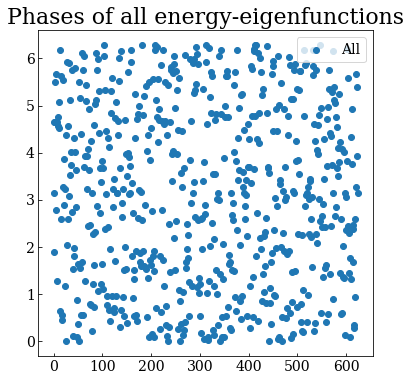

In [4]:
# Now we want to examine phases of all eigenvectors

fig, ax = plt.subplots(figsize= (6,6))

indices = np.arange(0,len(evecs))

# First we plot all phases
ax.scatter(x= indices, y= evec_phases, label= 'All')

ax.legend()
ax.set_title('Phases of all energy-eigenfunctions')
plt.show()

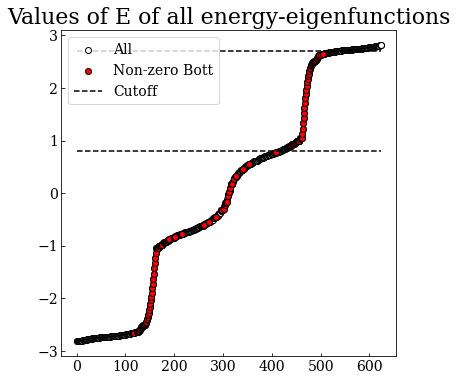

In [5]:
# Plot of E as a function of site number
fig, ax = plt.subplots(figsize= (6,6))

xs = np.arange(0,len(evecs))

# First we plot all phases
ax.scatter(x= xs, y= evals, edgecolor= 'k', facecolor= 'w', label= 'All')

# Now we highlight all with interesting Bott indices
# First select only bott indices
b_indices = [x[1] for x in bott_indices]
ys_ex = [evals[i] for i in b_indices]
ax.scatter(x= b_indices, y= ys_ex, edgecolor= 'k', facecolor= 'r', label= 'Non-zero Bott')

cutoff_low = 0.8
cutoff_high = 2.7
ax.hlines(y= cutoff_low, xmin= min(xs), xmax= max(xs), linestyles= '--', colors= 'k')
ax.hlines(y= cutoff_high, xmin= min(xs), xmax= max(xs), linestyles= '--', colors= 'k', label= 'Cutoff')

# These indicate the states with bott index of +/- 2
#ax.vlines(x= great_bott[0], ymin= min(evals), ymax= max(evals), linestyles= '--', colors= 'k')
#ax.vlines(x= great_bott[1], ymin= min(evals), ymax= max(evals), linestyles= '--', colors= 'k')

ax.legend()
ax.set_title('Values of E of all energy-eigenfunctions')
plt.show()

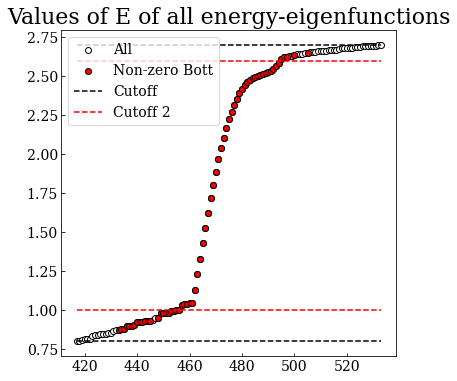

In [6]:
# Filter according to the above cutoff
filt_evals = [(ele, i) for i, ele in enumerate(evals) if cutoff_low <= ele and ele <= cutoff_high]

# Plot of E as a function of site number
fig, ax = plt.subplots(figsize= (6,6))

xs = [i for ele, i in filt_evals]
ys = [ele for ele, i in filt_evals]

# First we plot all phases
ax.scatter(x= xs, y= ys, edgecolor= 'k', facecolor= 'w', label= 'All')

# Now we highlight all with interesting Bott indices
# First select only bott indices
b_indices = [x[1] for x in bott_indices]
eles_ex_temp = []
for ele, i in filt_evals:
    ele_temp = [(ele, i) for x in b_indices if i == x]
    eles_ex_temp.append(ele_temp)
eles_ex = [item for sublist in eles_ex_temp for item in sublist]

xs_ex = [i for ele, i in eles_ex]
ys_ex = [ele for ele, i in eles_ex]

ax.scatter(x= xs_ex, y= ys_ex, edgecolor= 'k', facecolor= 'r', label= 'Non-zero Bott')

ax.hlines(y= cutoff_low, xmin= min(xs), xmax= max(xs), linestyles= '--', colors= 'k')
ax.hlines(y= cutoff_high, xmin= min(xs), xmax= max(xs), linestyles= '--', colors= 'k', label= 'Cutoff')

cutoff_low2 = 1
cutoff_high2 = 2.6

ax.hlines(y= cutoff_low2, xmin= min(xs), xmax= max(xs), linestyles= '--', colors= 'r')
ax.hlines(y= cutoff_high2, xmin= min(xs), xmax= max(xs), linestyles= '--', colors= 'r', label= 'Cutoff 2')


ax.legend()
ax.set_title('Values of E of all energy-eigenfunctions')
plt.show()

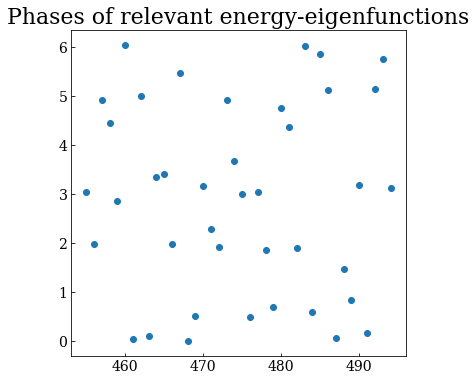

In [7]:
# Filter again and check for rotation eigenvalues
filt_evals2 = [(ele, i) for i, ele in enumerate(evals) if cutoff_low2 <= ele and ele <= cutoff_high2]
# Now filter for only relevant Bott indices
BI = [i for x,i in bott_indices]
filt_evals_BI = [(ele,i) for ele,i in filt_evals2 if i in BI]
filt_phases2 = [evec_phases[i] for ele, i in filt_evals_BI]

botts_used = [x for x,i in bott_indices if i in filt_evals_BI]

# Plot of E as a function of site number
fig, ax = plt.subplots(figsize= (6,6))

xs = [i for ele, i in filt_evals_BI]
ys = [ele for ele, i in filt_evals_BI]
# First we plot all phases
ax.scatter(x= xs, y= filt_phases2)

ax.set_title('Phases of relevant energy-eigenfunctions')
plt.show()

In [10]:
# Now we look to plot DOS for the different eigenvectors

relevant_in = [i for ele, i in filt_evals2]

relevant_evecs = [evecs[i] for i in relevant_in]

for index, phi in zip(relevant_in, relevant_evecs):
    densities = [(x.conj() * x).real for x in phi]

    # Define figure
    fig, ax = plt.subplots(figsize=(8,8))

    # Plot all possible paths between vertices
    for i,j in zip(grid_translated, jump_translated):
        xs = [w[0] for w in j]
        ys = [w[1] for w in j]
        for l,k in zip(xs,ys):
            ax.plot([i[0], l], [i[1], k], color= 'k', zorder= 1, linewidth= 1)

    marker_size = 30

    xs = [w[0] for w in grid_translated]
    ys = [w[1] for w in grid_translated]

    # Set colour gradient
    plt.set_cmap('hot_r')

    # Plot, noting c sets the density
    cax = ax.scatter(x= xs, y= ys, s= marker_size, c= densities, zorder= 3)

    # Attach colorbar
    cbar = fig.colorbar(cax)
    #cbar.ax.set_yticks()

    # Finalize
    plt.axis('equal')
    plt.title(r'State $= {}$, $\phi / \phi_0 = {}$'.format(index, B_scaling))

    plt.savefig(f'Non_zero_BI_state_in_gap/index_{index}', bbox_inches= 'tight')
    plt.close()

In [11]:
# Time evolve
def time_evolve_evec(group_of_states, coefficients, time, evec, eval):

    hbar = 1
    t = time

    # Make the group of states in to vectors and multiply with time op
    phis = [c*np.exp(-1j*(eval[i]/hbar)*t)*evec[i] for i, c in zip(group_of_states, coefficients)]

    # Make a linear combination equally divided
    a = len(phis)
    psi = sum([x for x in phis])

    phi_norm = psi / (np.sqrt(np.vdot(psi,psi)))

    density_of_states = [(x.conj() * x).real for x in phi_norm]
    
    return phi_norm, density_of_states


In [15]:
# After looking through plots the following indices have been determined to be relevant
group = [462, 463]

# We check that they have different phases, they have
phases = [evec_phases[i] for i in group]

print(phases)

[5.0060191633352575, 0.10290742721197316]


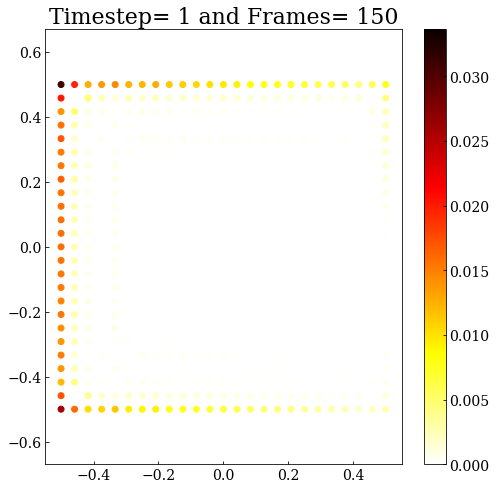

In [17]:
## Magic line for animation
%matplotlib inline
# Attempt at animating time evolution

# Set figure up first
fig, ax = plt.subplots(figsize=(8,8))
# Set bascis
sites = ax.scatter(x=[], y=[], c=[])

xs = [w[0] for w in grid_translated]
ys = [w[1] for w in grid_translated]

# Set timesteps, state of choice for animation, and number of frames
timestep = 1
n_frames = 150
coefs = [1,1]

group_of_choice = group
psi_0, dos_0 = time_evolve_evec(group_of_choice, coefs, 0, evecs, evals)

dos_max = max(dos_0)

plt.set_cmap('hot_r')
#cax = ax.scatter(x= xs, y= ys, s= marker_size, c= dos_max, zorder= 2)


# This function will do the animating
def update(i):
    plt.clf()
    # t is the steps we progress, timestep sets the steplength
    t = i * timestep

    # Using the time evolution to find density of states for each increment
    psi, dos = time_evolve_evec(group_of_choice, coefs, t, evecs, evals)
    cf = plt.scatter(x= xs, y= ys, c= dos, vmin=0, vmax= dos_max)
    plt.title(f'Timestep= {timestep} and Frames= {n_frames}')
    plt.colorbar(cf)
    plt.axis('equal')


anim = FuncAnimation(fig, update, frames= n_frames, interval=250)

name = test_list ='_'.join([str(x) for x in group])

anim.save(f'time_evolve/index_{name}.gif', writer='imagemagick', fps=24)

#anim

In [23]:
for t in np.arange(0,22.5,7.5):
    # Set figure up first
    fig, ax = plt.subplots(figsize=(6,6))

    # Plot all possible paths between vertices
    for i,j in zip(grid_translated, jump_translated):
        xs = [w[0] for w in j]
        ys = [w[1] for w in j]
        for l,k in zip(xs,ys):
            ax.plot([i[0], l], [i[1], k], color= 'k', zorder= 1, linewidth= 0.5)

    # Get points for scatter plot
    xs = [w[0] for w in grid_translated]
    ys = [w[1] for w in grid_translated]

    # Time evolution segment
    #B_scale = 0.25
    # Initial setup
    coefs = [1,1]
    psi_0, dos_0 = time_evolve_evec(group, coefs, 0, evecs, evals)
    dos_max = max(dos_0)

    # Actual evolution
    time = t
    psi, dos = time_evolve_evec(group, coefs, time, evecs, evals)

    # Plotting part
    cf = plt.scatter(x= xs, y= ys, c= dos, vmin=0, vmax= dos_max)
    plt.colorbar(cf)
    plt.axis('equal')

    plt.set_cmap('hot_r')
    plt.savefig(f'TE_frames/periodic_edge_time_{t}.png', bbox_inches= 'tight')
    plt.close()